In [ ]:
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier head with a new one for your dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)  # 2 classes: background + your object

model.roi_heads.mask_predictor = None
# We don't need masks; just bounding box prediction.
# So, it becomes Faster R-CNN

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 116MB/s]


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        self.image_ids = list(annotations.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Load image
        image_id = self.image_ids[idx]
        # image_path = f"{self.image_dir}/{image_id}.png"
        # image = Image.open(image_path).convert("RGB")
        image_path = None
        for ext in [".png", ".jpg", ".jpeg", ".tiff", ".bmp"]:  # Add more extensions if needed
          candidate_path = os.path.join(self.image_dir, f"{image_id}{ext}")
          if os.path.exists(candidate_path):
              image_path = candidate_path
              break
        image = Image.open(image_path).convert("RGB")

        # Load annotations
        bbox = self.annotations[image_id]  # (left, top, right, bottom)
        boxes = torch.tensor([bbox], dtype=torch.float32)  # Convert to tensor
        labels = torch.tensor([1], dtype=torch.int64)  # Class ID (1 for your object)

        # Create target dictionary
        target = {
            "boxes": boxes, # Shape: [1, 4]
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),  # Area = H * W
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)  # Assume no crowd
        }

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, target

(Updated)

70-15-15 split

Regular 70-15-15 data split

In [ ]:
from torchvision.transforms import functional as F

# Define paths
image_dir = "/content/resized/"  # Folder containing your images
annotations = true_csv_hashM  # Your dictionary of annotations

# Create dataset
dataset = CustomDataset(image_dir, annotations, transform=F.to_tensor)

# Split into training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Split into training, validation, and test sets
train_size = int(0.70 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

Test Piths

In [24]:
import pandas as pd

pith_pixel_hashM = {}

pith_data = pd.read_csv("/content/final_piths/pith_pixels.csv")

df = pd.DataFrame(pith_data)

# Image : (X, Y)
pith_pixel_hashM = {}

for i in range(len(df)):
  row = list(df.iloc[i, 0:3])
  pith_pixel_hashM[row[0]] = (int(row[1]), int(row[2]))

print(pith_pixel_hashM)

{'_OF297': (263, 406), '_OF293': (257, 474), '_OF292': (332, 375), '_OF291': (393, 379), '_OF290': (354, 381), '_OF287': (409, 374), '_OF286S2': (454, 420), '_OF286': (455, 424), '_OF285': (299, 426), '_OF283': (256, 378), '_OF282': (142, 442)}


In [25]:
from PIL import Image, ImageDraw
import os

pith_csv_hashM = {}

marked_folder = '/content/marked_piths/'
os.makedirs(marked_folder, exist_ok=True)

# ROI box size
roi_size = 20
half_roi = roi_size // 2

# resize + draw ROI
for file in os.listdir('/content/final_piths/'):
  if file == ".ipynb_checkpoints" or file == "pith_pixels.csv":
    continue
  # Open image
  img = Image.open('/content/final_piths/' + file)
  orig_width, orig_height = img.size

  # Remove ".png" extension from the file name
  file_name = file.replace(".png", "")
  print(file_name)

  # Get original coordinates (y, x) from new_csv_hashM
  if file_name in pith_pixel_hashM:
      x, y = pith_pixel_hashM[file_name]

      # Convert to integers
      x, y = int(x), int(y)

      # Define ROI box coordinates
      left = max(0, x - half_roi)
      top = max(0, y - half_roi)
      right = min(img.width, x + half_roi + 1)
      bottom = min(img.height, y + half_roi + 1)

      # Draw ROI box (filled with black, red outline)
      draw = ImageDraw.Draw(img)
      draw.rectangle([left, top, right, bottom], fill="black", outline="red", width=2)

      pith_csv_hashM[file_name] = (left, top, right, bottom)

      # Save the image with the ROI box
      file_png = f"{file_name}.png"
      img.save(os.path.join(marked_folder, file_png))

print(f"Images with ROI saved to {marked_folder}")

_OF283
_OF293
_OF286
_OF290
_OF291
_OF286S2
_OF287
_OF285
_OF282
_OF292
_OF297
Images with ROI saved to /content/marked_piths/


In [ ]:
print(pith_csv_hashM)

In [27]:
from torchvision.transforms import functional as F

# Define paths
image_dir = "/content/final_piths/"
annotations = pith_csv_hashM

# Create dataset
test_piths = CustomDataset(image_dir, annotations, transform=F.to_tensor)

In [28]:
model.eval()  # Set the model to evaluation mode

# Store IoU scores for each image
iou_scores = []

# Iterate over the test set
for images, targets in test_piths:
  # If targets is a dictionary, put into a list
  if isinstance(targets, dict):
    targets = [targets]

  # print("Targets:", targets)

    # Move images and targets to the correct device
    # images = list(image.to(device) for image in images)
    images = [image.unsqueeze(0).to(device) for image in images]

    targets = [{k: v.to(device) if hasattr(v, 'to') else v for k, v in t.items()} for t in targets]

    # Run inference
    with torch.no_grad():
        predictions = model(images)

    # Compare predictions with ground truth
    for i, (pred, target) in enumerate(zip(predictions, targets)):
        # Extract predicted and ground truth boxes
        pred_boxes = pred["boxes"].cpu().numpy()  # Shape: [N, 4]
        target_boxes = target["boxes"].cpu().numpy()  # Shape: [M, 4]

        # Compute IoU for each predicted box
        for pred_box in pred_boxes:
            for target_box in target_boxes:
                iou_score = iou(pred_box, target_box)
                iou_scores.append(iou_score)

# Compute average IoU
average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU on test set: {average_iou:.4f}")

Average IoU on test set: 0.2797


In [ ]:
# for images, targets in test_piths:
#     # print("Targets:", targets)
#     break  # Print only the first batch for debugging

In [29]:
from torchvision.ops import nms

def apply_nms(predictions, iou_threshold=0.5):
    """
    Apply Non-Maximum Suppression (NMS) to filter out overlapping boxes.
    Args:
        predictions: A dictionary containing "boxes", "scores", and "labels".
        iou_threshold: IoU threshold for NMS.
    Returns:
        A dictionary with filtered boxes, scores, and labels.
    """
    # Apply NMS
    keep_indices = nms(predictions["boxes"], predictions["scores"], iou_threshold)
    return {
        "boxes": predictions["boxes"][keep_indices],
        "scores": predictions["scores"][keep_indices],
        "labels": predictions["labels"][keep_indices]
    }

# Example usage during inference
model.eval()  # Set the model to evaluation mode

# Store IoU scores for each image
iou_scores = []

# Iterate over the test set
for images, targets in test_piths:
    if isinstance(targets, dict):
      targets = [targets]

    images = [image.unsqueeze(0).to(device) for image in images]
    # Move images and targets to the correct device
    images = list(image.to(device) for image in images)


    targets = [{k: v.to(device) if hasattr(v, 'to') else v for k, v in t.items()} for t in targets]

    # Run inference
    with torch.no_grad():
        predictions = model(images)

    # Compare predictions with ground truth
    for i, (pred, target) in enumerate(zip(predictions, targets)):
        # Apply NMS to filter out overlapping boxes
        filtered_pred = apply_nms(pred, iou_threshold=0.5)

        # Keep only the box with the highest confidence score
        if len(filtered_pred["boxes"]) > 0:
            best_box_index = torch.argmax(filtered_pred["scores"])
            best_box = filtered_pred["boxes"][best_box_index].cpu().numpy()
        else:
            best_box = None

        # Extract ground truth boxes
        target_boxes = target["boxes"].cpu().numpy()  # Shape: [M, 4]

        # Compute IoU for the best predicted box
        if best_box is not None:
            for target_box in target_boxes:
                iou_score = iou(best_box, target_box)
                iou_scores.append(iou_score)

# Compute average IoU
average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU on test set: {average_iou:.4f}")


Average IoU on test set: 0.5594


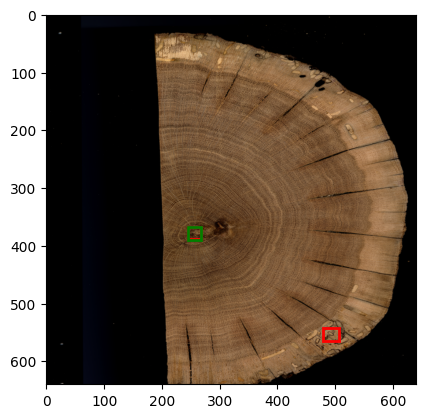

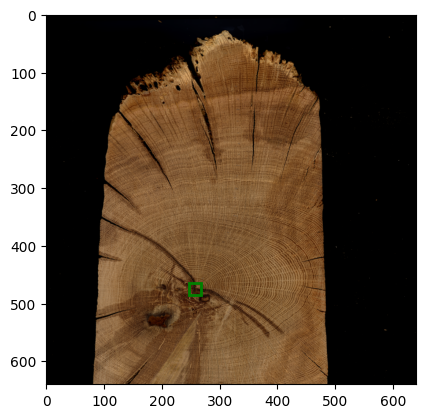

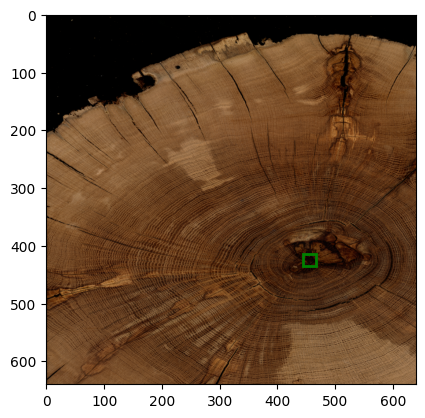

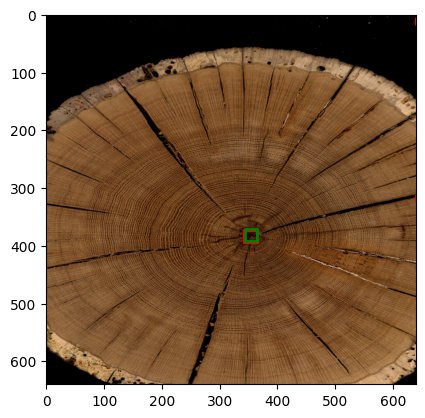

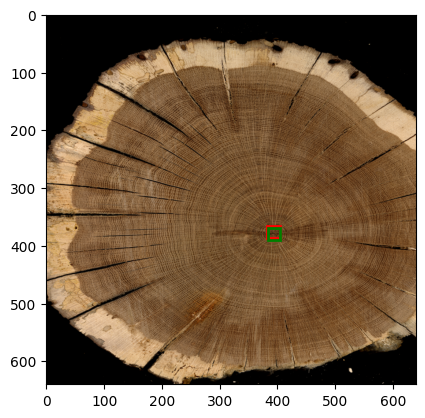

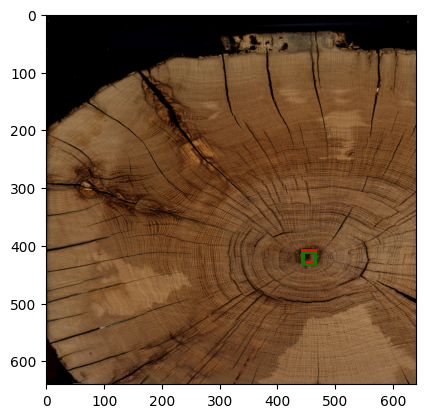

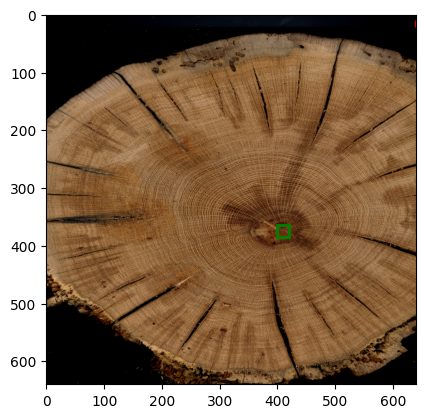

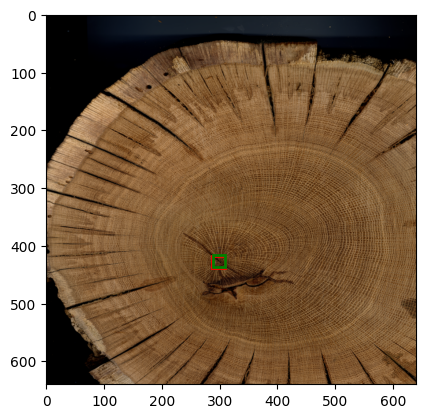

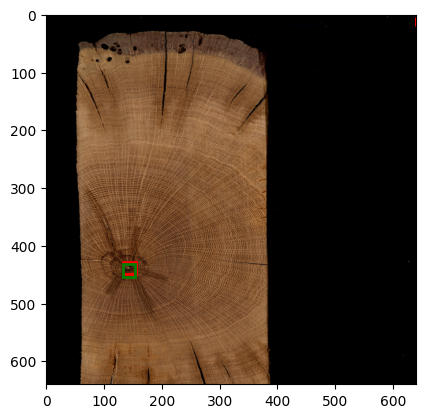

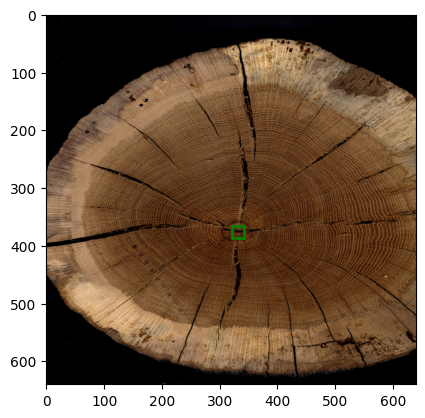

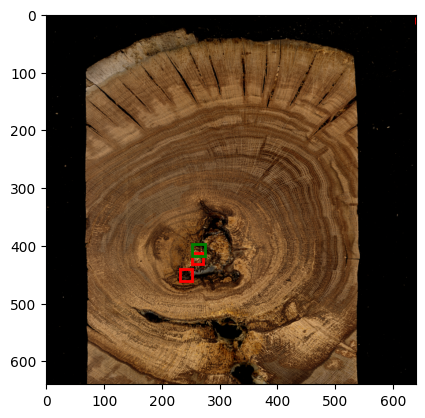

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, pred_boxes, target_boxes):
    """
    Visualize predicted and ground truth bounding boxes on an image.
    """
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw predicted boxes (in red)
    for box in pred_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)

    # Draw ground truth boxes (in green)
    for box in target_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor="g", facecolor="none"
        )
        ax.add_patch(rect)

    plt.show()

for i in range(len(test_piths)):
  # Visualize predictions for the test image
  image, target = test_piths[i]
  with torch.no_grad():
      prediction = model([image.to(device)])[0]

  visualize_predictions(
      image.cpu().permute(1, 2, 0).numpy(),  # Convert image to numpy array
      prediction["boxes"].cpu().numpy(),  # Predicted boxes
      target["boxes"].cpu().numpy()  # Ground truth boxes
  )

In [31]:
def compute_metrics(predictions, targets, iou_threshold=0.5):
    """
    Compute Precision, Recall, and F1-Score for object detection.
    Args:
        predictions: List of predicted bounding boxes (one list per image).
        targets: List of ground truth bounding boxes (one list per image).
        iou_threshold: IoU threshold for matching.
    Returns:
        Precision, Recall, F1-Score.
    """
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    for pred_boxes, target_boxes in zip(predictions, targets):
        # Initialize matched ground truth boxes
        matched = [False] * len(target_boxes)

        # Compare each predicted box to all ground truth boxes
        for pred_box in pred_boxes:
            max_iou = 0
            best_match_idx = -1

            # Find the best matching ground truth box
            for i, target_box in enumerate(target_boxes):
                iou_score = iou(pred_box, target_box)
                if iou_score > max_iou:
                    max_iou = iou_score
                    best_match_idx = i

            # Check if the best match meets the IoU threshold
            if max_iou >= iou_threshold:
                if not matched[best_match_idx]:
                    tp += 1  # True Positive
                    matched[best_match_idx] = True
                else:
                    fp += 1  # False Positive (duplicate detection)
            else:
                fp += 1  # False Positive (no match)

        # Count False Negatives (unmatched ground truth boxes)
        fn += len(target_boxes) - sum(matched)

    # Compute Precision, Recall, and F1-Score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score


# Example usage
predictions = []  # List of predicted boxes for each image
targets = []  # List of ground truth boxes for each image

# Iterate over the test set
for images, targets_batch in test_piths:
    # Move images and targets to the correct device
    if isinstance(targets_batch, dict):
          targets_batch = [targets_batch]

    images = [image.unsqueeze(0).to(device) for image in images]
    # Move images and targets to the correct device
    images = list(image.to(device) for image in images)


    targets_batch = [{k: v.to(device) if hasattr(v, 'to') else v for k, v in t.items()} for t in targets_batch]

    # Run inference
    with torch.no_grad():
        predictions_batch = model(images)

    # Apply NMS and keep all filtered boxes
    for pred, target in zip(predictions_batch, targets_batch):
        filtered_pred = apply_nms(pred, iou_threshold=0.5)
        pred_boxes = filtered_pred["boxes"].cpu().numpy()
        # print(f"Predictions: {pred_boxes}")
        predictions.append(pred_boxes)

        # Extract ground truth boxes
        target_boxes = target["boxes"].cpu().numpy()
        # print(f"Targets: {target_boxes}")

        targets.append(target_boxes)

# Compute metrics
precision, recall, f1_score = compute_metrics(predictions, targets, iou_threshold=0.5)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")

Precision: 0.3889, Recall: 0.6364, F1-Score: 0.4828


(Updated)

Training loop with both training error and validation error recorded

In [ ]:
from torchvision.transforms.functional import rotate
import math
import random

# Function to add random colored (from black to white grey shades) circles to an image
def add_random_circles(image, num_circles):
    """
    Add random small circles to image.
    """
    _, h, w = image.shape
    middle_third_h = h // 3
    middle_third_w = w // 3

    for _ in range(num_circles):
        # circle center within middle 1/3 of image
        cx = random.randint(middle_third_w, 2 * middle_third_w)
        cy = random.randint(middle_third_h, 2 * middle_third_h)

        # circle radius (<= 15 pixels, so diameter <= 30 pixels)
        radius = random.randint(5, 15)

        # circle stays within image bounds
        x_min = max(0, cx - radius)
        x_max = min(w, cx + radius)
        y_min = max(0, cy - radius)
        y_max = min(h, cy + radius)

        # Randomly choose circle color (black to white, including shades of gray)
        color = random.uniform(0, 1)  # Random value between 0 (black) and 1 (white)

        # Draw the circle
        for x in range(x_min, x_max):
            for y in range(y_min, y_max):
                if (x - cx) ** 2 + (y - cy) ** 2 <= radius ** 2:
                    image[:, y, x] = color  # Set pixel to the chosen color

    return image

# Function to rotate bounding boxes
def rotate_boxes(boxes, angle, image_size):
    """
    Rotate bounding boxes by a given angle.
    Bounding boxes are Tensors of [N, 4] (x1, y1, x2, y2).
    Returns new, rotated bounding boxes
    """
    h, w = image_size
    center = torch.tensor([w / 2, h / 2])  # Image center

    # Convert angle to radians
    angle_rad = math.radians(angle)

    # Rotation matrix
    rotation_matrix = torch.tensor([
        [math.cos(angle_rad), -math.sin(angle_rad)],
        [math.sin(angle_rad), math.cos(angle_rad)]
    ])

    # Rotate each box
    rotated_boxes = []
    for box in boxes:
        # Get box corners
        x1, y1, x2, y2 = box
        corners = torch.tensor([
            [x1, y1],
            [x2, y1],
            [x1, y2],
            [x2, y2]
        ])

        # Translate corners to origin (center of image)
        corners -= center

        # Rotate corners
        rotated_corners = torch.matmul(corners, rotation_matrix)

        # Translate corners back
        rotated_corners += center

        # Get new bounding box
        x_min = rotated_corners[:, 0].min()
        y_min = rotated_corners[:, 1].min()
        x_max = rotated_corners[:, 0].max()
        y_max = rotated_corners[:, 1].max()

        rotated_boxes.append([x_min, y_min, x_max, y_max])

    return torch.tensor(rotated_boxes)

In [ ]:
# del torch
# del torchvision
# del torch.optim
# del torch.nn

In [ ]:
# !pip install torch

In [ ]:
import os
from PIL import Image

# Define the source and target directories
source_dir = "/content/resized"  # Folder containing the original images
target_dir = "/content/resized_png"  # Folder to save the converted .png images

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Iterate through all files in the source directory
for filename in os.listdir(source_dir):
    # Get the full path of the file
    file_path = os.path.join(source_dir, filename)

    # Open the image
    with Image.open(file_path) as img:
        # Convert to RGB (in case the image is in a different mode)
        img = img.convert("RGB")

        # Save the image as .png in the target directory
        new_filename = os.path.splitext(filename)[0] + ".png"  # Replace the extension with .png
        new_file_path = os.path.join(target_dir, new_filename)
        img.save(new_file_path, "PNG")

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        self.image_ids = list(annotations.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Load image
        image_id = self.image_ids[idx]
        image_path = f"{self.image_dir}/{image_id}.png"
        image = Image.open(image_path).convert("RGB")
        # image = Image.open(image_path).convert("RGB")

        # Load annotations
        bbox = self.annotations[image_id]  # (left, top, right, bottom)
        boxes = torch.tensor([bbox], dtype=torch.float32)  # Convert to tensor
        labels = torch.tensor([1], dtype=torch.int64)  # Class ID (1 for your object)

        # Create target dictionary
        target = {
            "boxes": boxes, # Shape: [1, 4]
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),  # Area = H * W
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)  # Assume no crowd
        }

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, target

In [ ]:
import shutil
shutil.make_archive('resize_archive', 'zip', 'resized')

'/content/resize_archive.zip'

In [8]:
import torch.optim as optim
import torch
import os
# from torch.optim.lr_scheduler import StepLR

# Move model to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.85, weight_decay=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.6)

# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)

def collate_fn(batch):
    images, targets = zip(*batch)  # Unzip the list of (image, target) tuples
    images = list(images)
    targets = list(targets)  # targets will be a list of dictionaries
    return images, targets

# Define DataLoader with collate_fn

# Define data loaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=9, shuffle=True, num_workers=2, collate_fn=collate_fn)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=9, shuffle=False, num_workers=2, collate_fn=collate_fn)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=2, collate_fn=collate_fn)

train_errors = []
val_errors = []


# Training loop
num_epochs = 15 #25
for epoch in range(num_epochs):
    model.train()
    print(f"Epoch #{epoch+1}")

    for images, targets in train_loader:
        # print(type(targets))  # Check type of targets
        # print(targets)
        if isinstance(targets, dict):
          targets = [targets]

        for t in targets:
          t["boxes"] = t["boxes"].squeeze(1)  # Remove extra dimension

        # print(f"Num of images: {len(images)}")
        # print(f"Num of targets: {len(targets)}")
        # print(f"`targets` structure: {targets}")

        targets = [{k: v.to(device) if hasattr(v, 'to') else v for k, v in t.items()} for t in targets]

        images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Augment data: rotating images / bounding boxes
        augmented_images = []
        augmented_targets = []
        for image, target in zip(images, targets):
            for angle in range(0, 360, 24):  # Rotate by 24 degrees (15 rotations)
                # Rotate image
                rotated_image = rotate(image, angle)

                # Add random circles with varying colors
                num_circles = random.randint(0, 15)  # Random num of circles (0 to 15)
                rotated_image = add_random_circles(rotated_image, num_circles)

                # Rotate bounding boxes
                rotated_boxes = rotate_boxes(target["boxes"], angle, image.shape[1:])

                # Create new target
                rotated_target = {
                    "boxes": rotated_boxes.to(device),
                    "labels": target["labels"].to(device)
                }

                # Append to augmented data
                augmented_images.append(rotated_image)
                augmented_targets.append(rotated_target)


        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {losses.item()}")

    # Track training error
    train_errors.append(losses.item())

    # Validation error calculation
    model.train()  # Keep model in train mode
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            # to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if hasattr(v, 'to') else v for k, v in t.items()} for t in targets]

            # Forward pass (compute losses)
            loss_dict = model(images, targets)  # Model returns losses
            losses = sum(loss for loss in loss_dict.values())

            val_loss += losses.item()

            # val_loss += 0

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}")
    val_errors.append(val_loss / len(val_loader))  # Track validation error


Epoch #1
Epoch 1/15, Loss: 0.12994058430194855
Epoch 1/15, Validation Loss: 0.10289709601137373
Epoch #2
Epoch 2/15, Loss: 0.10395631194114685
Epoch 2/15, Validation Loss: 0.0847819530301624
Epoch #3
Epoch 3/15, Loss: 0.06600338965654373
Epoch 3/15, Validation Loss: 0.07980744706259833
Epoch #4
Epoch 4/15, Loss: 0.05645182356238365
Epoch 4/15, Validation Loss: 0.08411830332544115
Epoch #5
Epoch 5/15, Loss: 0.08552587032318115
Epoch 5/15, Validation Loss: 0.0753129045996401
Epoch #6
Epoch 6/15, Loss: 0.043679818511009216
Epoch 6/15, Validation Loss: 0.07684317396746741
Epoch #7
Epoch 7/15, Loss: 0.05900828167796135
Epoch 7/15, Validation Loss: 0.07549245779712994
Epoch #8
Epoch 8/15, Loss: 0.04400356486439705
Epoch 8/15, Validation Loss: 0.0727399339278539
Epoch #9
Epoch 9/15, Loss: 0.035173479467630386
Epoch 9/15, Validation Loss: 0.07147923774189419
Epoch #10
Epoch 10/15, Loss: 0.040821366012096405
Epoch 10/15, Validation Loss: 0.07153189720378982
Epoch #11
Epoch 11/15, Loss: 0.041893

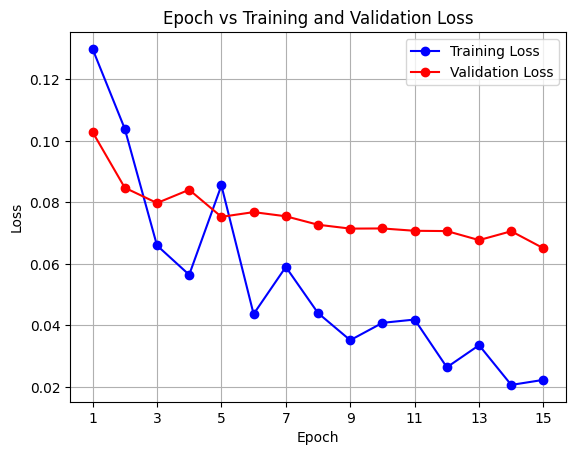

In [11]:
import matplotlib.pyplot as plt


epochs = range(1, 16)
# Create the plot

plt.plot(epochs, train_errors, marker='o', color='b', label='Training Loss')
plt.plot(epochs, val_errors, marker='o', color='r', label='Validation Loss')

# Adding labels and title
plt.title('Epoch vs Training and Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(1, 16, 2))
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Save the model state_dict
torch.save(model.state_dict(), "/content/model.pth")

# Optionally, save the optimizer's state_dict to resume training later
torch.save(optimizer.state_dict(), "/content/optimizer.pth")

In [ ]:
# Load model later with pretrained=True (or False ?)

# Load the model state_dict
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.load_state_dict(torch.load("model.pth"))

# Optionally, load the optimizer state_dict if you want to resume training
optimizer.load_state_dict(torch.load("optimizer.pth"))

IoU (Intersection over Union) evaluation metric

In [12]:
# https://medium.com/@prathameshamrutkar3/the-complete-guide-to-object-detection-evaluation-metrics-from-iou-to-map-and-more-1a23c0ea3c9d

def iou(bbox_a, bbox_b):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.
    Args:
        bbox_a: List or tensor of shape [4] (x_min, y_min, x_max, y_max).
        bbox_b: List or tensor of shape [4] (x_min, y_min, x_max, y_max).
    Returns:
        IoU score (float).
    """
    # Convert to tensors if necessary
    if not isinstance(bbox_a, torch.Tensor):
        bbox_a = torch.tensor(bbox_a)
    if not isinstance(bbox_b, torch.Tensor):
        bbox_b = torch.tensor(bbox_b)

    # Extract coordinates
    ax1, ay1, ax2, ay2 = bbox_a
    bx1, by1, bx2, by2 = bbox_b

    # Compute intersection coordinates
    ix1 = max(ax1, bx1)
    iy1 = max(ay1, by1)
    ix2 = min(ax2, bx2)
    iy2 = min(ay2, by2)

    # Compute intersection area
    intersection = max(0, ix2 - ix1) * max(0, iy2 - iy1)

    # Compute areas of both bounding boxes
    box1_area = (ax2 - ax1) * (ay2 - ay1)
    box2_area = (bx2 - bx1) * (by2 - by1)

    # Compute union area
    union = box1_area + box2_area - intersection

    # Avoid division by zero
    if union == 0:
        return 0.0

    return intersection / union

In [13]:
model.eval()  # Set the model to evaluation mode

# Store IoU scores for each image
iou_scores = []

# Iterate over the test set
for images, targets in test_dataset:
  # If targets is a dictionary, put into a list
  if isinstance(targets, dict):
    targets = [targets]

  # print("Targets:", targets)

    # Move images and targets to the correct device
    # images = list(image.to(device) for image in images)
    images = [image.unsqueeze(0).to(device) for image in images]

    targets = [{k: v.to(device) if hasattr(v, 'to') else v for k, v in t.items()} for t in targets]

    # Run inference
    with torch.no_grad():
        predictions = model(images)

    # Compare predictions with ground truth
    for i, (pred, target) in enumerate(zip(predictions, targets)):
        # Extract predicted and ground truth boxes
        pred_boxes = pred["boxes"].cpu().numpy()  # Shape: [N, 4]
        target_boxes = target["boxes"].cpu().numpy()  # Shape: [M, 4]

        # Compute IoU for each predicted box
        for pred_box in pred_boxes:
            for target_box in target_boxes:
                iou_score = iou(pred_box, target_box)
                iou_scores.append(iou_score)

# Compute average IoU
average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU on test set: {average_iou:.4f}")

Average IoU on test set: 0.3062


Using NMS (Non-Maximum Suppression) to filter out overlapping boxes using IoU score threshold (iou_threshold=0.5)

In [18]:
from torchvision.ops import nms

def apply_nms(predictions, iou_threshold=0.5):
    """
    Apply Non-Maximum Suppression (NMS) to filter out overlapping boxes.
    Args:
        predictions: A dictionary containing "boxes", "scores", and "labels".
        iou_threshold: IoU threshold for NMS.
    Returns:
        A dictionary with filtered boxes, scores, and labels.
    """
    # Apply NMS
    keep_indices = nms(predictions["boxes"], predictions["scores"], iou_threshold)
    return {
        "boxes": predictions["boxes"][keep_indices],
        "scores": predictions["scores"][keep_indices],
        "labels": predictions["labels"][keep_indices]
    }

# Example usage during inference
model.eval()  # Set the model to evaluation mode

# Store IoU scores for each image
iou_scores = []

# Iterate over the test set
for images, targets in test_loader: # Not over the val_loader
    # Move images and targets to the correct device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) if hasattr(v, 'to') else v for k, v in t.items()} for t in targets]

    # Run inference
    with torch.no_grad():
        predictions = model(images)

    # Compare predictions with ground truth
    for i, (pred, target) in enumerate(zip(predictions, targets)):
        # Apply NMS to filter out overlapping boxes
        filtered_pred = apply_nms(pred, iou_threshold=0.5)

        # Keep only the box with the highest confidence score
        if len(filtered_pred["boxes"]) > 0:
            best_box_index = torch.argmax(filtered_pred["scores"])
            best_box = filtered_pred["boxes"][best_box_index].cpu().numpy()
        else:
            best_box = None

        # Extract ground truth boxes
        target_boxes = target["boxes"].cpu().numpy()  # Shape: [M, 4]

        # Compute IoU for the best predicted box
        if best_box is not None:
            for target_box in target_boxes:
                iou_score = iou(best_box, target_box)
                iou_scores.append(iou_score)

# Compute average IoU
average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU on test set: {average_iou:.4f}")


Average IoU on test set: 0.7970


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, pred_boxes, target_boxes):
    """
    Visualize predicted and ground truth bounding boxes on an image.
    Args:
        image: PIL Image or numpy array.
        pred_boxes: Predicted bounding boxes (shape [N, 4]).
        target_boxes: Ground truth bounding boxes (shape [M, 4]).
    """
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw predicted boxes (in red)
    for box in pred_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)

    # Draw ground truth boxes (in green)
    for box in target_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor="g", facecolor="none"
        )
        ax.add_patch(rect)

    plt.show()

for i in range(len(val_dataset)):
  # Visualize predictions for the test image
  image, target = val_dataset[i]
  with torch.no_grad():
      prediction = model([image.to(device)])[0]

  visualize_predictions(
      image.cpu().permute(1, 2, 0).numpy(),  # Convert image to numpy array
      prediction["boxes"].cpu().numpy(),  # Predicted boxes
      target["boxes"].cpu().numpy()  # Ground truth boxes
  )

In [34]:
def compute_metrics(predictions, targets, iou_threshold=0.5):
    """
    Compute Precision, Recall, and F1-Score for object detection.
    Args:
        predictions: List of predicted bounding boxes (one list per image).
        targets: List of ground truth bounding boxes (one list per image).
        iou_threshold: IoU threshold for matching.
    Returns:
        Precision, Recall, F1-Score.
    """
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    for pred_boxes, target_boxes in zip(predictions, targets):
        # Initialize matched ground truth boxes
        matched = [False] * len(target_boxes)

        # Compare each predicted box to all ground truth boxes
        for pred_box in pred_boxes:
            max_iou = 0
            best_match_idx = -1

            # Find the best matching ground truth box
            for i, target_box in enumerate(target_boxes):
                iou_score = iou(pred_box, target_box)
                if iou_score > max_iou:
                    max_iou = iou_score
                    best_match_idx = i

            # Check if the best match meets the IoU threshold
            if max_iou >= iou_threshold:
                if not matched[best_match_idx]:
                    tp += 1  # True Positive
                    matched[best_match_idx] = True
                else:
                    fp += 1  # False Positive (duplicate detection)
            else:
                fp += 1  # False Positive (no match)

        # Count False Negatives (unmatched ground truth boxes)
        fn += len(target_boxes) - sum(matched)

    # Compute Precision, Recall, and F1-Score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score


# Example usage
predictions = []  # List of predicted boxes for each image
targets = []  # List of ground truth boxes for each image

# Iterate over the test set
for images, targets_batch in test_loader:
    # Move images and targets to the correct device
    images = list(image.to(device) for image in images)
    targets_batch = [{k: v.to(device) if hasattr(v, 'to') else v for k, v in t.items()} for t in targets_batch]

    # Run inference
    with torch.no_grad():
        predictions_batch = model(images)

    # Apply NMS and keep all filtered boxes
    for pred, target in zip(predictions_batch, targets_batch):
        filtered_pred = apply_nms(pred, iou_threshold=0.5)
        pred_boxes = filtered_pred["boxes"].cpu().numpy()
        predictions.append(pred_boxes)

        # Extract ground truth boxes
        target_boxes = target["boxes"].cpu().numpy()
        targets.append(target_boxes)

# Compute metrics
precision, recall, f1_score = compute_metrics(predictions, targets, iou_threshold=0.5)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")

Precision: 0.3784, Recall: 0.9545, F1-Score: 0.5419
